# Estrategias de Trading

- Señales de trading (*trading signals*)
- Estrategias de tendencia (*trend strategies*)
- Estrategias de reversión a la media (*mean reverting strategies*)
- Optimización y Benchmarking

## Señales de Trading

- Una señal de trading gatilla una orden de compra o venta basado en criterios predeterminados y reproducibles.
- Se puede construir con:
  - Un indicador técnico (cuantitativo)
  - Varios indicadores técnicos
  - Una combinación de datos de mercado e indicadores técnicos
- Son comúnmente utilizadas en el trading *algorítmico* (trading basado exclusivamente en reglas cuantitativas usualmente realizado por computadores).

### Ejemplo

- Señal: $Precio \gt SMA \Rightarrow Compra$ 

In [1]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
import talib

In [2]:
start = date(2019, 1, 1)
end = date(2021, 9, 30)
ticker = 'AAPL'
data_source = 'yahoo'
apple_data = web.DataReader(ticker, data_source, start, end)

In [3]:
apple_data['SMA_largo'] = talib.SMA(apple_data['Close'], timeperiod=100)

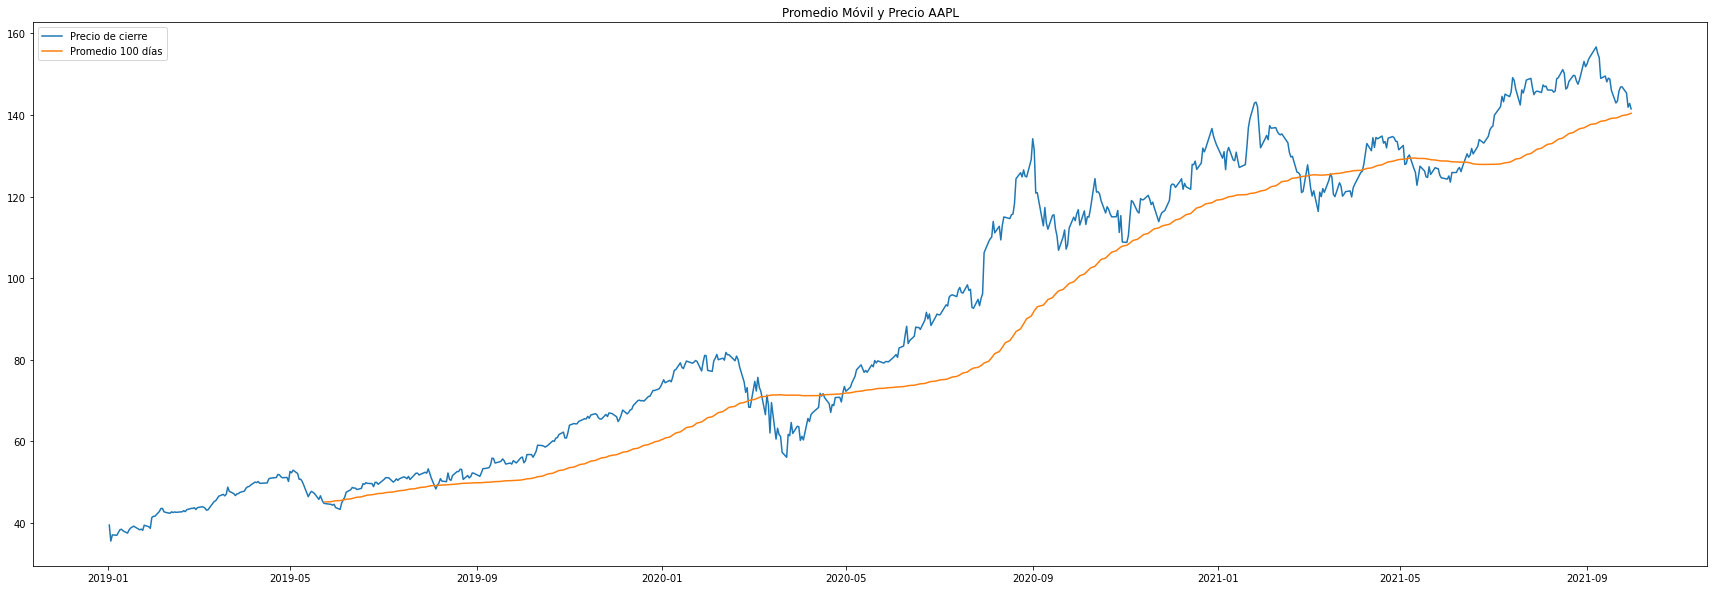

In [5]:
plt.plot(apple_data['Close'], label='Precio de cierre')
plt.plot(apple_data['SMA_largo'], label='Promedio 100 días')
plt.legend()
plt.title('Promedio Móvil y Precio AAPL')
plt.rcParams["figure.figsize"] = (30,10)
plt.show()

### Implementar Estrategias con `bt`

- Obtener la data y calcular indicadores
- Definir una estrategia basada en una señal
- Crear y ejecutar un backtest
- Revisar el resultado del backtest

In [6]:
import bt

#### Data e Indicadores

In [7]:
precios = bt.get('gm', start='2019-1-1', end='2021-10-5')

In [9]:
precios.tail()

,gm
Date,
2021-09-29,52.930000
2021-09-30,52.709999
2021-10-01,53.130001
2021-10-04,53.980000
2021-10-05,54.340000


In [12]:
sma = talib.SMA(precios['gm'], timeperiod=20).to_frame()
sma.columns = ['gm']

In [14]:
sma.tail()

,gm
Date,
2021-09-29,50.570
2021-09-30,50.750
2021-10-01,50.959
2021-10-04,51.217
2021-10-05,51.498


#### Definición de Estrategia

In [15]:
estrategia1 = bt.Strategy(
    'CompraSobrePromedio',
    [bt.algos.SelectWhere(precios > sma),
     bt.algos.WeighEqually(),
     bt.algos.Rebalance()]
)

Por simplicidad se asume que:

- Se opera un activo por vez
- No hay *slippage* (diferencia entre el precio esperado de la transacción y el precio real de la transacción)
- No hay comisiones

#### Crear y Ejecutar backtest

In [16]:
backtest1 = bt.Backtest(estrategia1, precios)

In [17]:
resultado1 = bt.run(backtest1)

/opt/tljh/user/lib/python3.7/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


#### Revisión de Resultado

<AxesSubplot:title={'center':'Resultado 1'}>

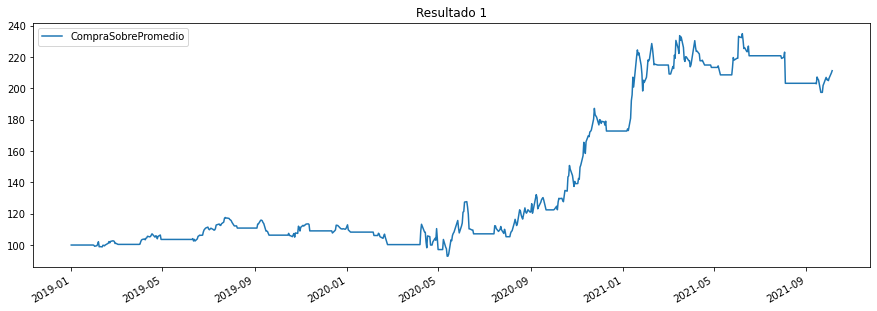

In [18]:
resultado1.plot(title='Resultado 1')

In [19]:
trans = resultado1.get_transactions()

In [21]:
trans.head(10)

,,price,quantity
Date,Security,,
2019-01-30,gm,37.060387,26982.0
2019-02-07,gm,36.643234,1.0
2019-03-04,gm,37.212078,-26983.0
2019-04-01,gm,36.154724,27772.0
2019-04-30,gm,37.294140,-27772.0
2019-06-10,gm,34.848610,29721.0
2019-08-05,gm,37.751854,-29721.0
2019-08-08,gm,38.806702,28913.0
2019-08-09,gm,38.332504,-28913.0


In [13]:
resultado1.display()

Stat                 CompraSobrePromedio
-------------------  ---------------------
Start                2019-01-01
End                  2021-10-05
Risk-free rate       0.00%

Total Return         111.33%
Daily Sharpe         1.06
Daily Sortino        1.87
CAGR                 31.14%
Max Drawdown         -21.02%
Calmar Ratio         1.48

MTD                  3.09%
3m                   -4.32%
6m                   -6.97%
YTD                  22.30%
1Y                   69.34%
3Y (ann.)            31.14%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  31.14%

Daily Sharpe         1.06
Daily Sortino        1.87
Daily Mean (ann.)    31.43%
Daily Vol (ann.)     29.60%
Daily Skew           0.86
Daily Kurt           6.67
Best Day             9.75%
Worst Day            -8.91%

Monthly Sharpe       1.24
Monthly Sortino      4.38
Monthly Mean (ann.)  30.19%
Monthly Vol (ann.)   24.26%
Monthly Skew         1.81
Monthly Kurt         4.18
Best Month           26.96%
Worst Month  

## Estrategias de Tendencia

- Se espera que el precio siga con la misma tendencia al alza o a la baja
- Para estas estrategias generalmente se utilizan indicadores de tendencia como promedios móviles o ADX

### Cruce de Promedios Móviles

- Se utilizan dos promedios móviles, uno de corto plazo y uno de más largo (o mediano) plazo
- Señal larga: la curva del promedio corto cruza desde abajo hacia arriba la curva del promedio largo
- Señal corta: la curva del promedio corto cruza desde arriba hacia abajo la curva del promedio largo

#### Cálculo de Indicadores

In [23]:
prom_corto = talib.SMA(precios['gm'], timeperiod=20).to_frame()
prom_corto.columns = ['gm']

prom_largo = talib.SMA(precios['gm'], timeperiod=40).to_frame()
prom_largo.columns = ['gm']

Se crea la señal.

In [24]:
signal1 = prom_largo.copy()

In [26]:
signal1[prom_largo.isnull()] = 0

In [28]:
signal1[prom_corto > prom_largo] = 1
signal1[prom_corto <= prom_largo] = -1

Se combina todo en un único `DataFrame`.

In [34]:
df_combinado1 = bt.merge(signal1, precios, prom_corto, prom_largo)
df_combinado1.columns = ['signal', 'precio', 'prom_corto', 'prom_largo']

Se grafica. Como la señal tiene una escala distinta al precio y a los promedios móviles se crea un gráfico a doble escala.

<AxesSubplot:xlabel='Date'>

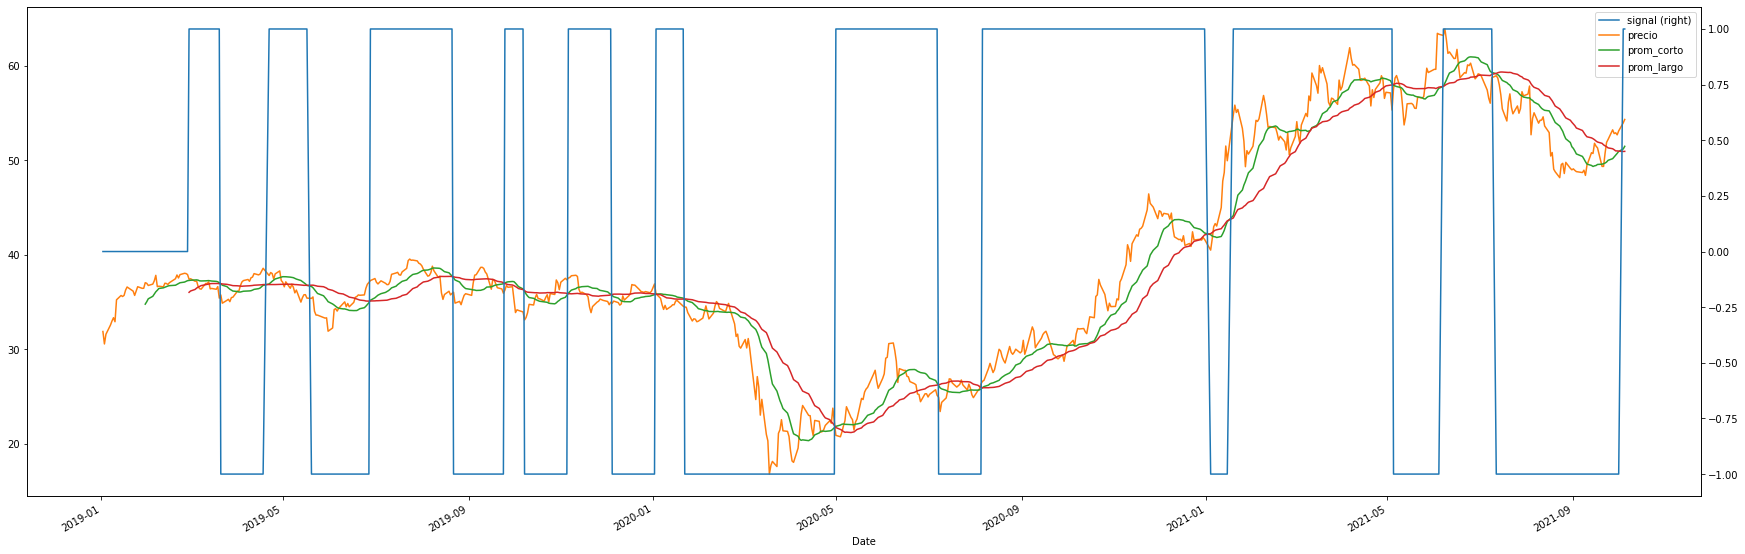

In [35]:
df_combinado1.plot(secondary_y=['signal'])

#### Se Define la Estrategia

In [36]:
estrategia2 = bt.Strategy(
    'cruce_promedios',
    [bt.algos.WeighTarget(signal1),
     bt.algos.Rebalance()]
)

#### Backtest

In [37]:
backtest2 = bt.Backtest(estrategia2, precios)
resultado2 = bt.run(backtest2)

<AxesSubplot:title={'center':'Cruce de Medias Aplicado a GM'}>

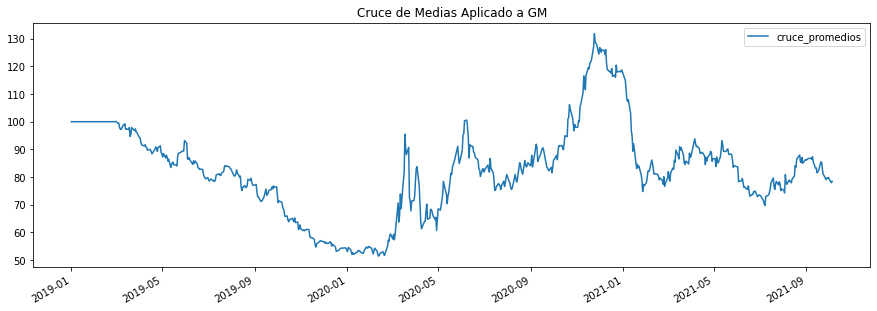

In [38]:
resultado2.plot(title='Cruce de Medias Aplicado a GM')

In [39]:
trans2 = resultado2.get_transactions()

In [40]:
trans2

,,price,quantity
Date,Security,,
2019-02-28,gm,37.430134,26716.0
2019-03-21,gm,35.762154,-53433.0
2019-03-22,gm,34.890846,-1334.0
2019-03-25,gm,35.187664,473.0
2019-03-26,gm,35.302563,179.0
...,...,...,...
2021-09-28,gm,52.849998,-219.0
2021-09-29,gm,52.930000,45.0
2021-09-30,gm,52.709999,-125.0


In [41]:
trans2.to_excel('tran2.xlsx')

## Estrategias de Reversión a la Media

- Se espera que la tendencia del precio cambie o que el precio revierta a su valor promedio
- Para estas estrategias se utilizan indicadores como el RSI o las bandas de Bollinger
- *Buy the fear and sell the greed*

### Basado en RSI

- Se utiliza el RSI
- Señal larga: $RSI \lt 30$. Sugiere que el activo está sobrevendido
- Señal corta: $RSI \gt 70$. Sugiere que el activo está sobrecomprado

#### Cálculo de Indicador

In [42]:
rsi = talib.RSI(precios['gm']).to_frame()
rsi.columns = ['gm']

Se crea la señal.

In [43]:
signal2 = rsi.copy()
signal2[rsi.isnull()] = 0

# Señal de compra
signal2[rsi < 30] = 1

# Señal de venta
signal2[rsi > 70] = -1

# No hacer nada
signal2[(rsi >= 30) & (rsi <= 70)] = 0

Se grafica.

<AxesSubplot:xlabel='Date'>

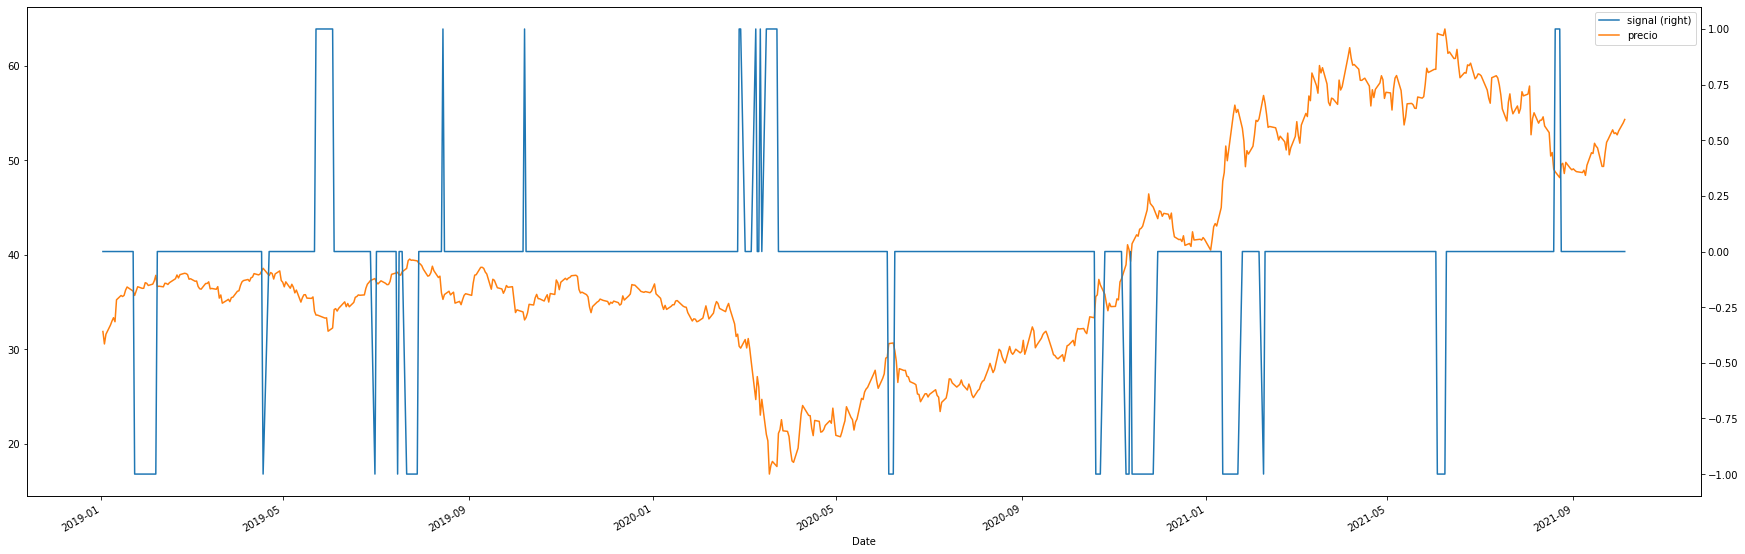

In [44]:
df_combinado2 = bt.merge(signal2, precios)
df_combinado2.columns = ['signal', 'precio']
df_combinado2.plot(secondary_y=['signal'])

#### Se Define la Estrategia

In [45]:
estrategia3 = bt.Strategy(
    'rsi_reversion',
    [bt.algos.WeighTarget(signal2),
     bt.algos.Rebalance()]
)

#### Backtest

In [46]:
backtest3 = bt.Backtest(estrategia3, precios)
resultado3 = bt.run(backtest3)

<AxesSubplot:title={'center':'RSI con GM'}>

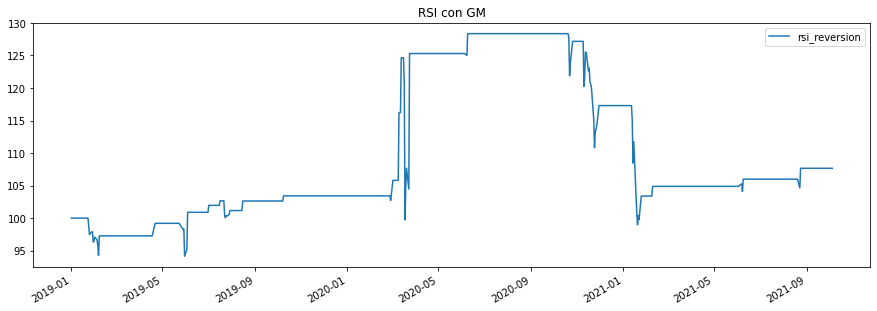

In [47]:
resultado3.plot(title='RSI con GM')

## Optimización y Benchmarking

¿Cómo se eligen los valores de los parámetros de cada estrategia? Por ejemplo, ¿cuáles son los períodos a utilizar en la estrategia de cruce de medias móviles?

Para esto se utiliza la optimización de estrategia, que consiste en testear la estrategia con una amplir rango de parámetros posibles y comprar los resultados.

### Optimización

Construyamos una función que retorne el resultado de una estrategia en particular en función de los parámetros de la estrategia.

In [48]:
def backtest_media_movil(nombre, precios, periodo):
    # Se calcula el indicador con pandas
    sma = precios.rolling(periodo).mean()

    # Se define la estrategia
    estrategia = bt.Strategy(
        nombre,
        [bt.algos.SelectWhere(precios > sma),
         bt.algos.WeighEqually(),
         bt.algos.Rebalance()]
    )
    
    # Retorna el backtest
    return bt.Backtest(estrategia, precios)

Se calcula el resultado para 3 períodos distintos:

In [65]:
backtests = []
for p in [10, 20, 30, 40, 50]:
    backtests.append(backtest_media_movil(f'SMA{p}', precios, p))

Se ejecutan los resultados.

In [66]:
resultados = bt.run(*backtests)

/opt/tljh/user/lib/python3.7/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


Se grafica.

<AxesSubplot:title={'center':'Resultados Estrategias Promedio Móvil con 20, 50 y 100 Días'}>

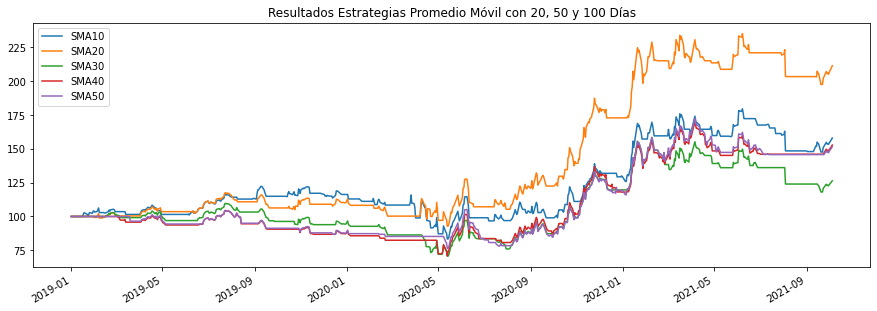

In [67]:
resultados.plot(title='Resultados Estrategias Promedio Móvil con 20, 50 y 100 Días')

In [68]:
resultados.lookback_returns

,SMA10,SMA20,SMA30,SMA40,SMA50
mtd,0.030923,0.030924,0.030923,0.030924,0.030923
3m,-0.057231,-0.043185,-0.071375,0.046610,0.013412
6m,-0.079420,-0.069671,-0.173760,-0.088467,-0.108124
ytd,0.220763,0.222962,0.056554,0.294549,0.271306
1y,0.565260,0.693416,0.420342,0.674712,0.709846
3y,0.180064,0.311446,0.088512,0.165990,0.162619
5y,NaN,NaN,NaN,NaN,NaN
10y,NaN,NaN,NaN,NaN,NaN
incep,0.180064,0.311446,0.088512,0.165990,0.162619


In [64]:
resultados.lookback_returns.loc['incep'].max()

0.31144586536394137

### Benchmark

Un *benchmark* es un punto de referencia contra el cual una estrategia puede ser comparada. Por ejemplo, una estrategia que utiliza señales para tradear acciones puede usar una estrategia pasiva de *buy and hold* como benchmark. Alternativamente, se puede usar la performance de cualquier índice accionario (relevante para el portfolio al cual se aplica la estrategia).

In [69]:
def buy_and_hold(precios, nombre):
    estrategia = bt.Strategy(
        nombre,
        [bt.algos.RunOnce(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()]
    )
    
    return bt.Backtest(estrategia, precios)

/opt/tljh/user/lib/python3.7/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


<AxesSubplot:title={'center':'Resultados Estrategias Promedio Móvil con 20, 50 y 100 Días y BH como Bchmrk'}>

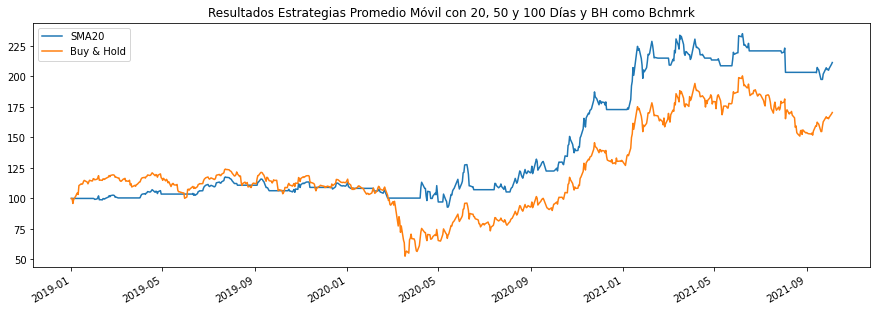

In [71]:
backtests.append(buy_and_hold(precios, 'Buy & Hold'))
resultados = bt.run(backtests[1], backtests[5])
resultados.plot(
    title='Resultados Estrategias Promedio Móvil con 20, 50 y 100 Días y BH como Bchmrk')